In [1]:
# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20 # 20 for 10 step prediction or even 58 frames
image_height, image_width = 32, 32
save_deriv1 = False
save_deriv2 = False

In [2]:
## Load the data:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []
xela_sensor1_data_x_final_1stderiv = []
xela_sensor1_data_y_final_1stderiv = []
xela_sensor1_data_z_final_1stderiv = []
xela_sensor1_data_x_final_2stderiv = []
xela_sensor1_data_y_final_2stderiv = []
xela_sensor1_data_z_final_2stderiv = []


ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0
cut = 0
for experiment_number in tqdm(range(len(files))):
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))
    
    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []
    
    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    # fix the euler angles:
    for i in range(len(ee_orientation_z)):
        if ee_orientation_z[i] < 0:
            ee_orientation_z[i] += 360

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]
    
    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]
    
    # calculate the derivatives
    if save_deriv1 == True:
        cut = 1
        xela_deriv1_x = np.diff(np.array(xela_sensor1_data_x), axis=0).tolist()
        xela_deriv1_y = np.diff(np.array(xela_sensor1_data_y), axis=0).tolist()
        xela_deriv1_z = np.diff(np.array(xela_sensor1_data_z), axis=0).tolist()
        # store the data:
        xela_sensor1_data_x_final_1stderiv += xela_deriv1_x 
        xela_sensor1_data_y_final_1stderiv += xela_deriv1_y 
        xela_sensor1_data_z_final_1stderiv += xela_deriv1_z 
        
    if save_deriv2 == True:
        cut = 2
        xela1_deriv2_x = np.diff(np.array(xela_sensor1_data_x), axis=0, n=2).tolist()
        xela1_deriv2_y = np.diff(np.array(xela_sensor1_data_y), axis=0, n=2).tolist()
        xela1_deriv2_z = np.diff(np.array(xela_sensor1_data_z), axis=0, n=2).tolist()
        # store the data:
        xela_sensor1_data_x_final_2stderiv += xela1_deriv2_x 
        xela_sensor1_data_y_final_2stderiv += xela1_deriv2_y 
        xela_sensor1_data_z_final_2stderiv += xela1_deriv2_z        
        
    xela_sensor1_data_x_final += xela_sensor1_data_x[cut:]
    xela_sensor1_data_y_final += xela_sensor1_data_y[cut:]
    xela_sensor1_data_z_final += xela_sensor1_data_z[cut:]
    ee_positions_final += ee_positions[cut:]
    ee_position_x_final += ee_position_x[cut:]
    ee_position_y_final += ee_position_y[cut:]
    ee_position_z_final += ee_position_z[cut:]
    ee_orientation_quat_x_final += ee_orientation_quat_x[cut:]
    ee_orientation_quat_y_final += ee_orientation_quat_y[cut:]
    ee_orientation_quat_z_final += ee_orientation_quat_z[cut:]
    ee_orientation_quat_w_final += ee_orientation_quat_w[cut:]
    ee_orientation_x_final += ee_orientation_x[cut:]
    ee_orientation_y_final += ee_orientation_y[cut:]
    ee_orientation_z_final += ee_orientation_z[cut:]

    exp_break_points.append(exp_break_point - cut)

100%|██████████| 218/218 [02:06<00:00,  1.72it/s]


In [3]:
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)

scale_together = False
if scale_together == True:
    xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
    scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
    xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
    min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_data_scaled)
    xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

elif scale_together == False:
    scaler_tx = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
    scaler_ty = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
    scaler_tz = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
    xelax_sensor1_data_scaled = scaler_tx.transform(xela_sensor1_data_x_final)
    xelay_sensor1_data_scaled = scaler_ty.transform(xela_sensor1_data_y_final)
    xelaz_sensor1_data_scaled = scaler_tz.transform(xela_sensor1_data_z_final)
    xela_sensor1_data_scaled = np.concatenate((xelax_sensor1_data_scaled,
                                               xelay_sensor1_data_scaled,
                                               xelaz_sensor1_data_scaled), axis=1)
    
    min_max_scalerx_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1_data_scaled)
    min_max_scalery_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1_data_scaled)
    min_max_scalerz_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1_data_scaled)    
    xelax_sensor1_data_scaled_minmax = min_max_scalerx_full_data.transform(xelax_sensor1_data_scaled)
    xelay_sensor1_data_scaled_minmax = min_max_scalery_full_data.transform(xelay_sensor1_data_scaled)
    xelaz_sensor1_data_scaled_minmax = min_max_scalerz_full_data.transform(xelaz_sensor1_data_scaled)

    xela_sensor1_data_scaled_minmax = np.concatenate((xelax_sensor1_data_scaled_minmax,
                                        xelay_sensor1_data_scaled_minmax,
                                        xelaz_sensor1_data_scaled_minmax), axis=1)
    
if save_deriv1 == True:
    scaler_td1x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_1stderiv)
    scaler_td1y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_1stderiv)
    scaler_td1z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_1stderiv)
    xelax_sensor1d1_data_scaled = scaler_td1x.transform(xela_sensor1_data_x_final_1stderiv)
    xelay_sensor1d1_data_scaled = scaler_td1y.transform(xela_sensor1_data_y_final_1stderiv)
    xelaz_sensor1d1_data_scaled = scaler_td1z.transform(xela_sensor1_data_z_final_1stderiv)
    xelad1_sensor1_data_scaled = np.concatenate((xelax_sensor1d1_data_scaled,
                                               xelay_sensor1d1_data_scaled,
                                               xelaz_sensor1d1_data_scaled), axis=1)
    
    min_max_scalerd1x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d1_data_scaled)
    min_max_scalerd1y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d1_data_scaled)
    min_max_scalerd1z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d1_data_scaled)    
    xelad1x_sensor1_data_scaled_minmax = min_max_scalerd1x_full_data.transform(xelax_sensor1d1_data_scaled)
    xelad1y_sensor1_data_scaled_minmax = min_max_scalerd1y_full_data.transform(xelay_sensor1d1_data_scaled)
    xelad1z_sensor1_data_scaled_minmax = min_max_scalerd1z_full_data.transform(xelaz_sensor1d1_data_scaled)

    xelad1_sensor1_data_scaled_minmax = np.concatenate((xelad1x_sensor1_data_scaled_minmax,
                                        xelad1y_sensor1_data_scaled_minmax,
                                        xelad1z_sensor1_data_scaled_minmax), axis=1)

if save_deriv2 == True:
    scaler_td2x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_2stderiv)
    scaler_td2y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_2stderiv)
    scaler_td2z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_2stderiv)
    xelax_sensor1d2_data_scaled = scaler_td2x.transform(xela_sensor1_data_x_final_2stderiv)
    xelay_sensor1d2_data_scaled = scaler_td2y.transform(xela_sensor1_data_y_final_2stderiv)
    xelaz_sensor1d2_data_scaled = scaler_td2z.transform(xela_sensor1_data_z_final_2stderiv)
    xelad2_sensor1_data_scaled = np.concatenate((xelax_sensor1d2_data_scaled,
                                               xelay_sensor1d2_data_scaled,
                                               xelaz_sensor1d2_data_scaled), axis=1)
    
    min_max_scalerd2x_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelax_sensor1d2_data_scaled)
    min_max_scalerd2y_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelay_sensor1d2_data_scaled)
    min_max_scalerd2z_full_data = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xelaz_sensor1d2_data_scaled)    
    xelad2x_sensor1_data_scaled_minmax = min_max_scalerd2x_full_data.transform(xelax_sensor1d2_data_scaled)
    xelad2y_sensor1_data_scaled_minmax = min_max_scalerd2y_full_data.transform(xelay_sensor1d2_data_scaled)
    xelad2z_sensor1_data_scaled_minmax = min_max_scalerd2z_full_data.transform(xelaz_sensor1d2_data_scaled)

    xelad2_sensor1_data_scaled_minmax = np.concatenate((xelad2x_sensor1_data_scaled_minmax,
                                        xelad2y_sensor1_data_scaled_minmax,
                                        xelad2z_sensor1_data_scaled_minmax), axis=1)


In [4]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 32
learning_rate = 1e-3
context_frames = 10
# sequence_length = 10 # 20 for 10 step prediction
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.95  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/"
################################# CHANGE THIS!!!!  #################################

In [5]:
# scale between 0 and 1:
ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final).reshape(-1, 1)
ee_orientation_x_final = np.array(ee_orientation_x_final)
ee_orientation_y_final = np.array(ee_orientation_y_final)
ee_orientation_z_final = np.array(ee_orientation_z_final)
# xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 
xela_sensor1_principle_components =  np.array(xela_sensor1_data_scaled)
if save_deriv1 == True:
    xelad1_sensor1_data_scaled_minmax = np.array(xelad1_sensor1_data_scaled_minmax)
if save_deriv2 == True:
    xelad2_sensor1_data_scaled_minmax = np.array(xelad2_sensor1_data_scaled_minmax)

min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

if scale_together == True:
    min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(xela_sensor1_principle_components)
    xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)
else:
    xela_sensor1_principle_components_scaled = xela_sensor1_data_scaled_minmax

if save_deriv1 == True:
    xelad1_sensor1_principle_components_scaled = xelad1_sensor1_data_scaled_minmax
if save_deriv2 == True:
    xelad2_sensor1_principle_components_scaled = xelad2_sensor1_data_scaled_minmax

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = np.asarray(np.split(xelad1_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = np.asarray(np.split(xelad2_sensor1_principle_components_scaled, exp_break_points)[0:-1])

# Shuffle data:
# p = np.random.permutation(len(ee_position_x_final_split))
# p = np.delete(p, np.where(p==106))  # make 106 always in the test set (for comparing graphs)
# p = np.append(p, [106])
p = np.load("/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_004/shuffle_order.npy", )
print("shuffle order: ", p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = xela_sensor1_data_1stderiv_scaled_split[p]
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = xela_sensor1_data_2stderiv_scaled_split[p]

ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []
xela_sensor1_principle_components = []
ee_position_x_final_scaled = []
ee_position_y_final_scaled = []
ee_position_z_final_scaled = []
ee_orientation_quat_x_final_scaled = []
ee_orientation_quat_y_final_scaled = []
ee_orientation_quat_z_final_scaled = []
ee_orientation_quat_w_final_scaled = []
ee_orientation_x_final_scaled = []
ee_orientation_y_final_scaled = []
ee_orientation_z_final_scaled = []
xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

xela_sensor1_data_x_final = []
xela_sensor1_data_y_final = []
xela_sensor1_data_z_final = []
xelax_sensor1_data_scaled_minmax = []
xelay_sensor1_data_scaled_minmax = []
xelaz_sensor1_data_scaled_minmax = []
xela_sensor1_data_scaled_minmax = []


# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
xela1_1stderiv_sequence = []
xela1_2stderiv_sequence = []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        xela_sensor1_1stderiv = []
        xela_sensor1_2stderiv = []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            if save_deriv1 == True:
                xela_sensor1_1stderiv.append(xela_sensor1_data_1stderiv_scaled_split[experiment][sample+t])
            if save_deriv2 == True:
                xela_sensor1_2stderiv.append(xela_sensor1_data_2stderiv_scaled_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        xela1_1stderiv_sequence.append(xela_sensor1_1stderiv)
        xela1_2stderiv_sequence.append(xela_sensor1_2stderiv)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)
        
# np.save(model_path + 'shuffle_order', np.asarray(p))

shuffle order:  [181   1 154 177 170 123 153 116 102 217  34  75  21  78 141 132 155   9
 130 200 201 115  29  22 208 179  53 174  41 120  76 180 105 108  47 103
 203 165  62  77 183 164  43 168  52  45  14 127 149 119  24 166  55  85
  72  15  59 150  12  65 209  68 172 213  87 178   2   6 190  30 113  50
 193  33  84 175  89 128 151 169  57 185  99  58 194  79 134 138 160 158
 101 144 214  92  40 176  60  10 148 192  16 137  26  38  83  56 198 122
 107  54 124   3  18  98  96 143  37 204 129   7  49  67  64  25   4 216
 131 197  73  69 171 162  63  48 152  71   8 210 110  42 136 111 133  94
  74  66  17 135 215 121  81 187 184  11 117 126  90 188  36  23 167  93
 191  31 100  35 159 195 205  32 202 140  61 146   0  13  51 186  97   5
 145 206 114  80 139  88  44 182 156  39  46 173 147  91 112 163  86 196
 212  82 189  28 211 199  20 207 161 157  95 125  27 118  19  70 109 104
 142 106]


In [6]:
class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        dataset_valid = FullDataSet(type_="valid")
        dataset_test = FullDataSet(type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "valid":
            self.samples = [int(len(robot_data_euler_sequence)*(valid_train_split)), int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "test":
            self.samples = [int(len(robot_data_euler_sequence)*test_train_split), len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
        robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        return([np.array(robot_euler).astype(np.float32),
                np.array(xela1).astype(np.float32),
                np.array(experiment),
                np.array(time_step)])

In [7]:
# single LSTM attempt
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48 + 48, 200).to(device)  # tactile
        self.lstm2 = nn.LSTM(200, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200 + 48, 200).to(device)  # tactile + pos_vel
        self.fc2 = nn.Linear(200, 48).to(device)  # tactile + pos_vel
        self.tan_activation = nn.Tanh().to(device)

    def forward(self, tactiles, actions, tac_deriv1, tac_deriv2):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))
        hidden2 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))

        for index, (sample_tactile, sample_action, sample_tactilederiv1, sample_tactilederiv1) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), tac_deriv1.squeeze(), tac_deriv2.squeeze()), ):
            # 2. Run through lstm:
            if index > context_frames-1:
                out4 = out4 .squeeze()
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((out4, tiled_action_and_state), 1)
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), out4), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
                outputs.append(out4.squeeze())
            else:
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((sample_tactile, tiled_action_and_state), 1)                
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), sample_tactile), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))

        return torch.stack(outputs)

In [ ]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        print("here3")
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].squeeze().permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)
                tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions, tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].squeeze().permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                    tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.                    
                    if save_deriv1 == True:
                        ground_truth = torch.cat((tactile[context_frames:],tactilederiv1[context_frames:]), 2)
                    else:
                        ground_truth = tactile[context_frames:]
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions[:,:,:48].to(device), ground_truth[:,:,:48])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    print("saving model")
                    torch.save(self.full_model, model_path + "trained_model")
                    self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
            plt.plot(plot_training_loss, c="r", label="train loss MAE")
            plt.plot(plot_validation_loss, c='b', label="val loss MAE")
            plt.legend(loc="upper right")
            plt.savefig(model_path + '/trining_plot_50steppred.png', dpi=300)
    #         plt.show()
            np.save(model_path + 'training_loss_50steppred', np.asarray(plot_training_loss))
            np.save(model_path + 'validation_loss_50steppred', np.asarray(plot_validation_loss))

In [ ]:
## create data generator, train model and save model.
BG = BatchGenerator()
print("here1")
MT = ModelTrainer()
print("here2")
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "trained_model_50steppred")
model = torch.load(model_path + "trained_model_50steppred")
model.eval()
print("saved the model")

from twilio.rest import Client
account_sid = "ACbb524ad1deed7bd1d53d2be7dd189de6"
auth_token = "9a0a01cddac5b0c827eb89a534fa897e"
client = Client(account_sid, auth_token)
FROM_NUM        = "+12562861398"
VERIFIED_NUMBER = "+447722355970"
message = client.messages.create(body='TESTING', from_=[FROM_NUM], to=[VERIFIED_NUMBER])
print(message.sid)

In [20]:
# test model on the full test sample:
BG = BatchGenerator()
model = torch.load(model_path + "trained_model")
model.eval()

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
BG = BatchGenerator()
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()

test_lossesMAE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMAE_scaled = 0.0
test_lossesMAE_t15 = 0.0
test_lossesMAE_t20 = 0.0
test_lossesMAE_t25 = 0.0
test_lossesMAE_t35 = 0.0
test_lossesMAE_t40 = 0.0
test_lossesMAE_t48 = 0.0

tactile_gt_test = []
tactile_gt_d1_test = []
tactile_gt_d2_test = []
action_test = []

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze(-1).permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].unsqueeze(2).permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].unsqueeze(2).permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)+1):
            if scale_together == False:
                if i is not 0:
                    # tp:
                    (tpx, tpy, tpz) = np.split(tp[i-1].cpu().detach(), 3, axis=1)
                    xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                    xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                    xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                    xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                    xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                    xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                    tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                         xela_y_inverse_full,
                                                         xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames-1:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                      xela_z_inverse_full), axis=1))
            else:
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))


        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        tactile_predictions.append(tp_back_scaled)
        tactile_groundtruth.append(tg_back_scaled)
        
        # for extended time step testing
        tactile_gt_test.append(tactile)
        tactile_gt_d1_test.append(tactilederiv1)
        tactile_gt_d2_test.append(tactilederiv2)
        action_test.append(action)

        # calculate losses for specific timesteps
        test_lossesMAE_scaled += criterion1(tp, tactile[context_frames:]).item()
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
#         test_lossMAE_t15 = criterion1(tp_back_scaled[14,:,:], tg_back_scaled[15,:,:])
#         test_lossesMAE_t15 += test_lossMAE_t15.item()
#         test_lossMAE_t20 = criterion1(tp_back_scaled[19,:,:], tg_back_scaled[20,:,:])
#         test_lossesMAE_t20 += test_lossMAE_t20.item()
#         test_lossMAE_t25 = criterion1(tp_back_scaled[24,:,:], tg_back_scaled[25,:,:])
#         test_lossesMAE_t25 += test_lossMAE_t25.item()
#         test_lossMAE_t35 = criterion1(tp_back_scaled[34,:,:], tg_back_scaled[35,:,:])
#         test_lossesMAE_t35 += test_lossMAE_t35.item()
#         test_lossMAE_t40 = criterion1(tp_back_scaled[39,:,:], tg_back_scaled[40,:,:])
#         test_lossesMAE_t40 += test_lossMAE_t40.item()
#         test_lossMAE_t48 = criterion1(tp_back_scaled[47,:,:], tg_back_scaled[48,:,:])
#         test_lossesMAE_t48 += test_lossMAE_t48.item()
        
performance_data = []
performance_data.append(["unscaled test loss MAE(L1): ", (test_lossesMAE_scaled / index__)])
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_t10 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 15: ", (test_lossesMAE_t15 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 20: ", (test_lossesMAE_t20 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 25: ", (test_lossesMAE_t25 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 35: ", (test_lossesMAE_t35 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 40: ", (test_lossesMAE_t40 / index__)])
# performance_data.append(["test loss MAE(L1) timestep 48: ", (test_lossesMAE_t48 / index__)])
[print(i) for i in performance_data]

# np.save(model_path + 'performance_data', np.asarray(performance_data))

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


[None, None, None, None, None]

In [46]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 1  # experiment 106 as its the last one

for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())
# print(aaaa)
# for index, batch_set in enumerate(tactile_predictions):
#     for batch in range(0, len(batch_set[0])):
#         experiment = experiment_time_steps[index][0][batch][0].numpy()
#         time_step = experiment_time_steps[index][1][batch][0].numpy()
#         if experiment == experiment_to_test:
#             predicted_data_t1.append(batch_set[time_step_to_test_t1][batch])
#             predicted_data_t5.append(batch_set[time_step_to_test_t5][batch])
#             predicted_data_t9.append(batch_set[time_step_to_test_t9][batch])
#             groundtruth_data.append(tactile_groundtruth[index][time_step_to_test_t1][batch])
#             time_stepsto_plot.append(time_step.item())
# print(aaaaaa)


tensor([48807.8805, 48806.8584, 48809.3497, 48821.9015, 48805.3681, 48805.6523,
        48802.6650, 48815.4527, 48803.7586, 48801.3932, 48814.9450, 48809.8821,
        48810.1750, 48803.9003, 48816.7097, 48802.4280, 16382.9827, 16382.5008,
        16378.7226, 16378.5050, 16392.5841, 16404.8998, 16395.9952, 16385.9966,
        16396.2547, 16399.6225, 16388.1764, 16383.2271, 16402.3568, 16398.7458,
        16394.2787, 16397.0623, 37383.7977, 37391.9423, 37406.9790, 37403.9856,
        37392.9940, 37415.4379, 37378.1901, 37398.2032, 37386.8461, 37405.4469,
        37348.7288, 37401.8123, 37400.7218, 37415.8071, 37397.3323, 37368.3378],
       dtype=torch.float64)


NameError: name 'aaa' is not defined

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

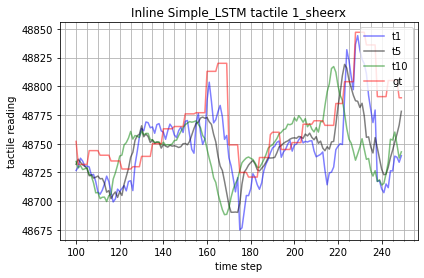

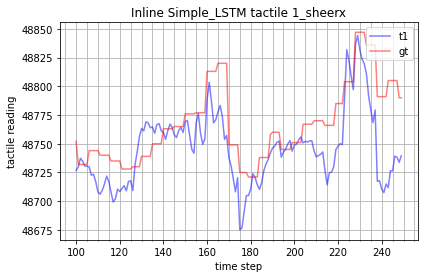

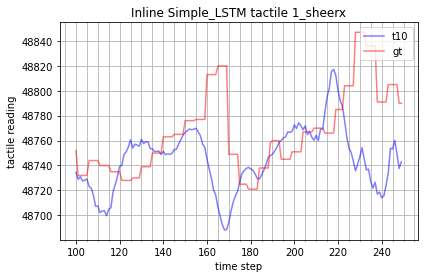

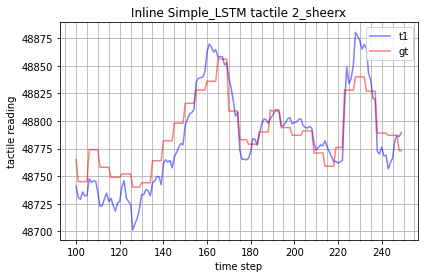

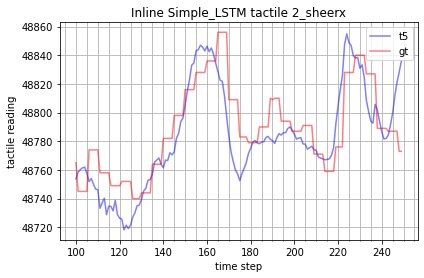

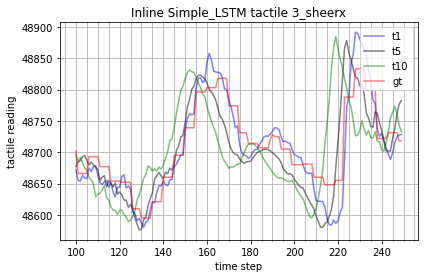

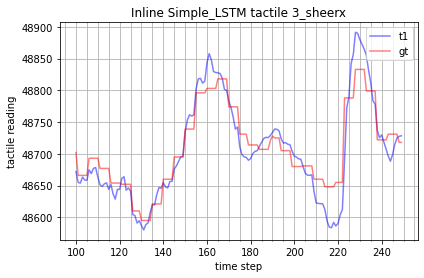

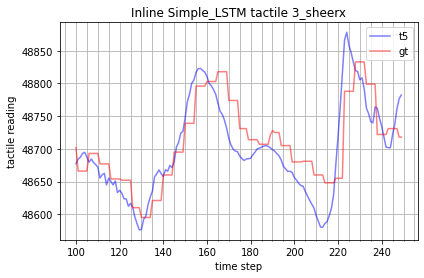

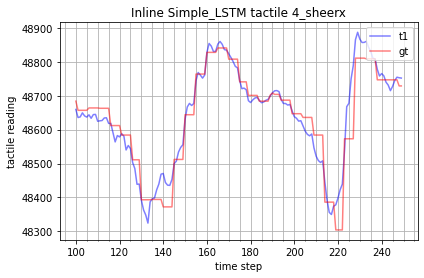

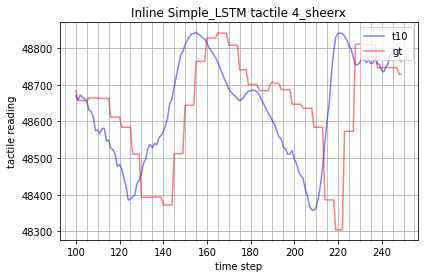

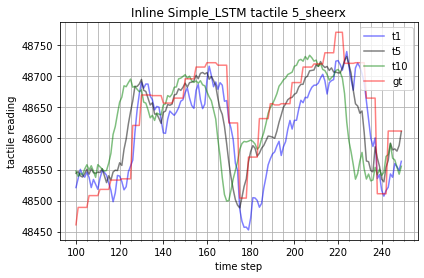

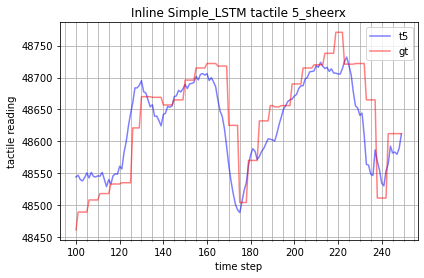

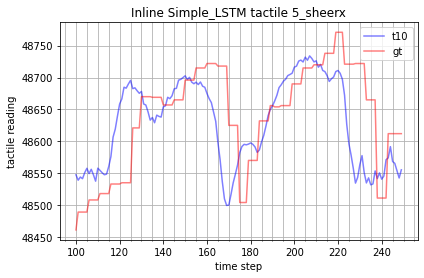

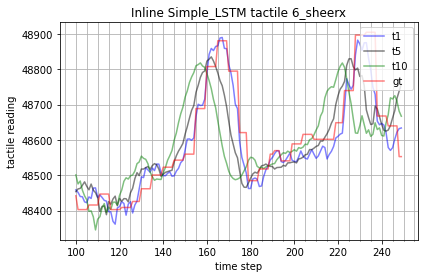

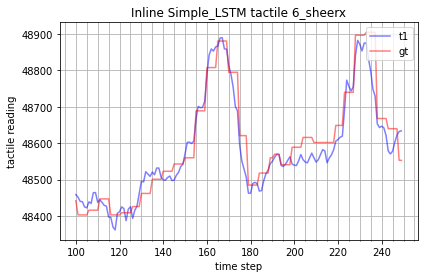

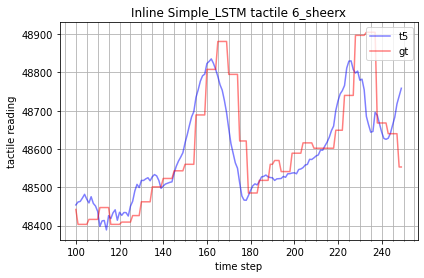

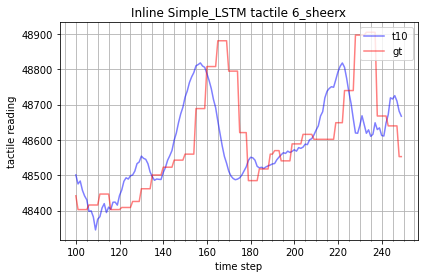

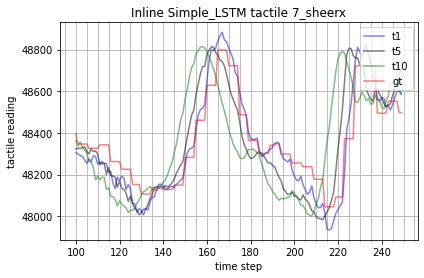

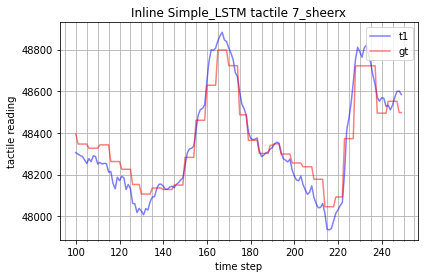

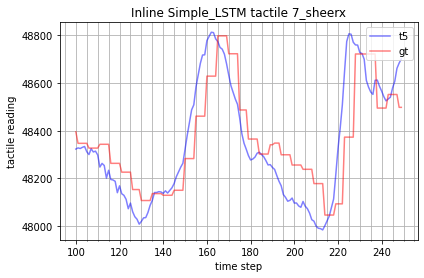

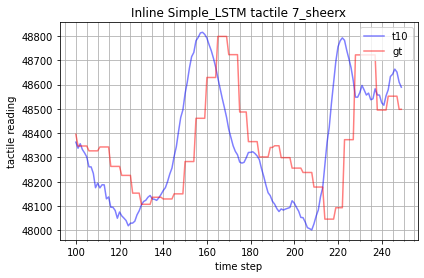

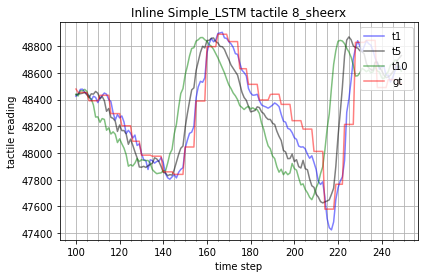

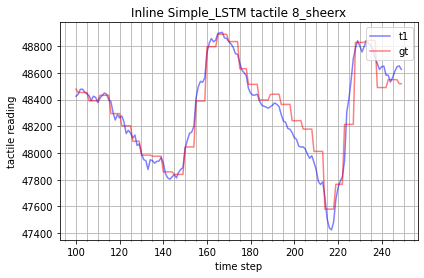

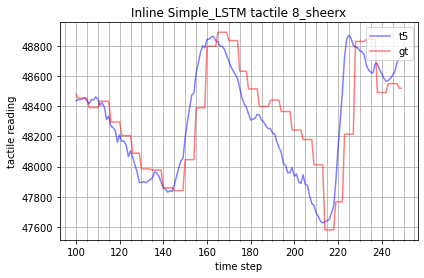

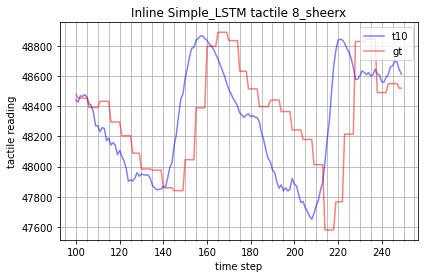

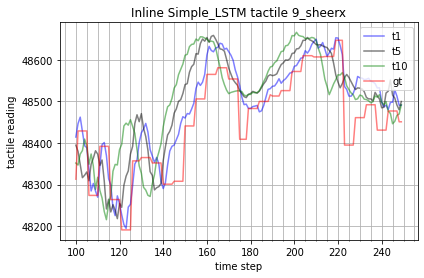

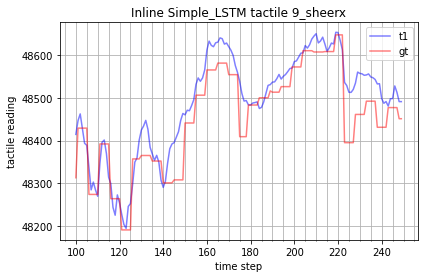

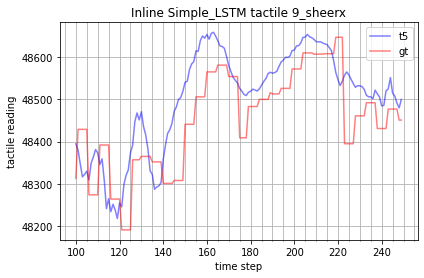

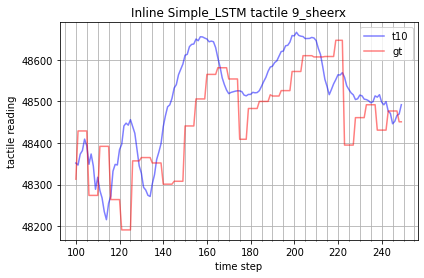

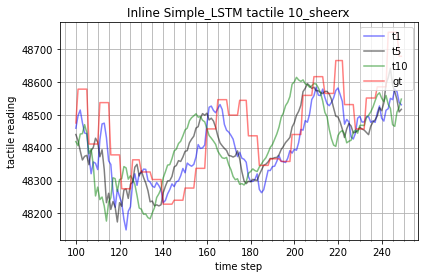

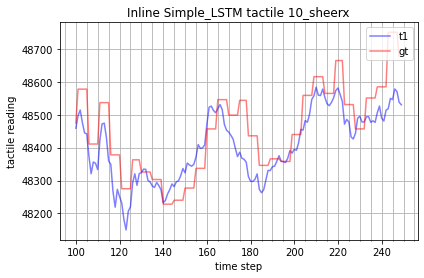

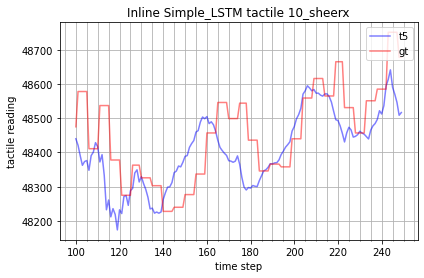

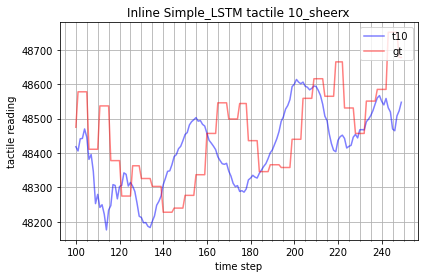

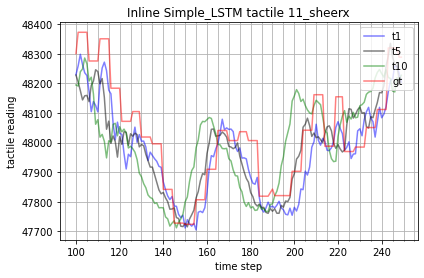

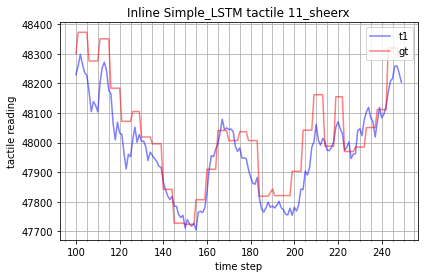

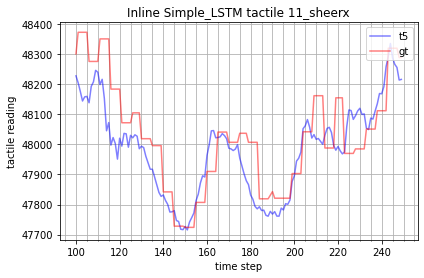

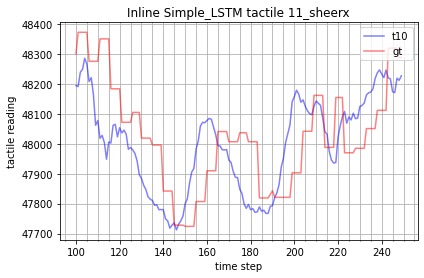

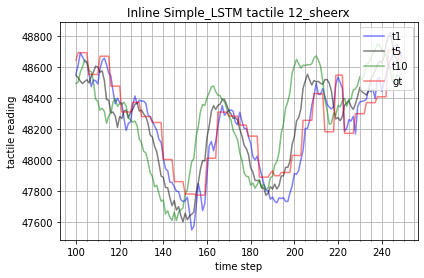

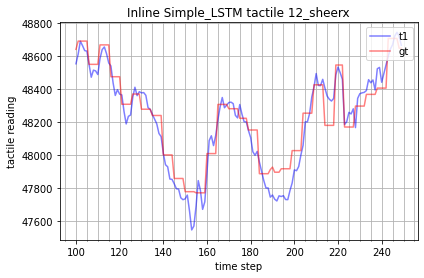

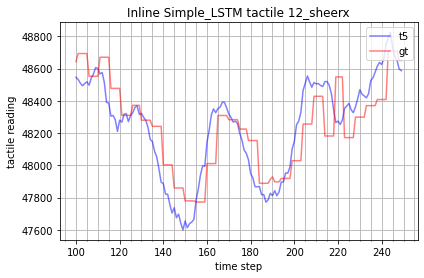

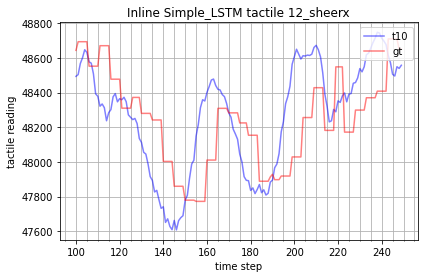

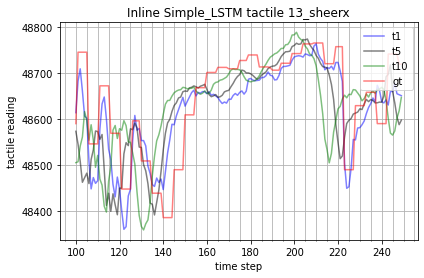

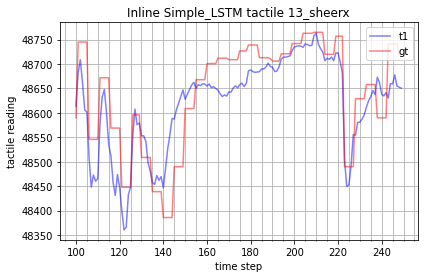

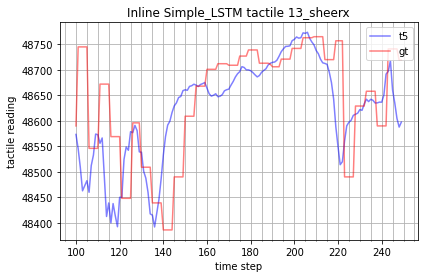

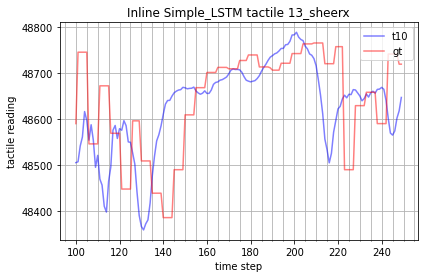

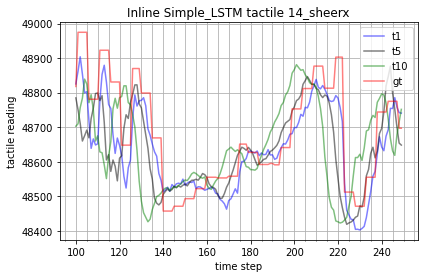

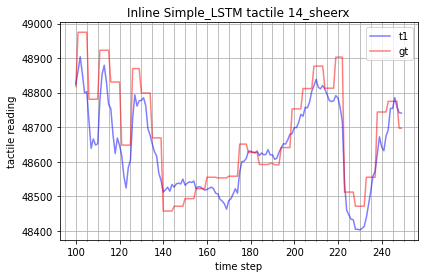

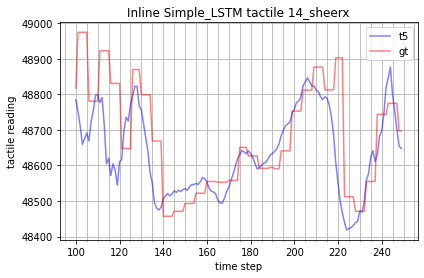

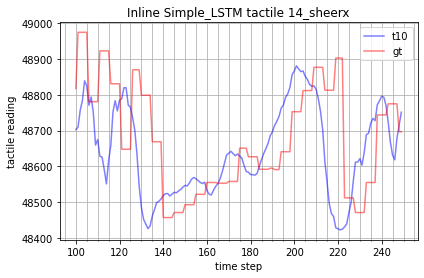

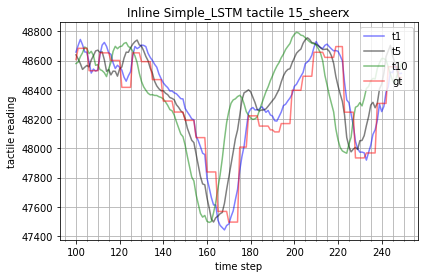

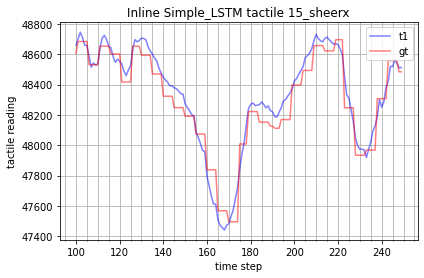

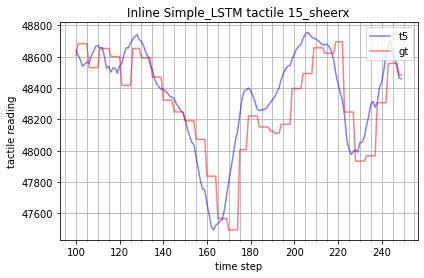

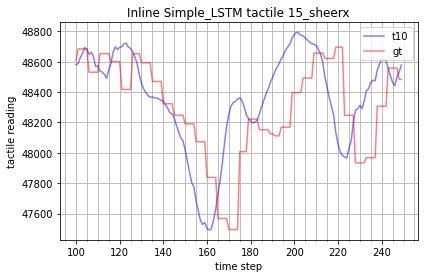

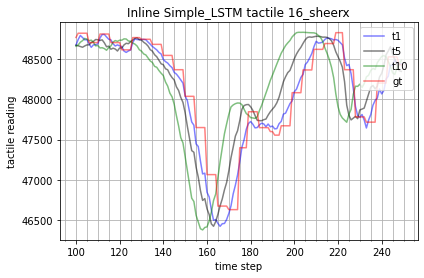

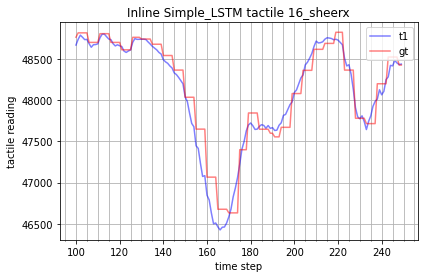

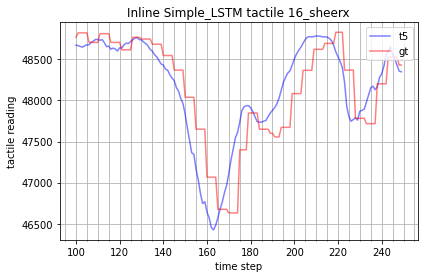

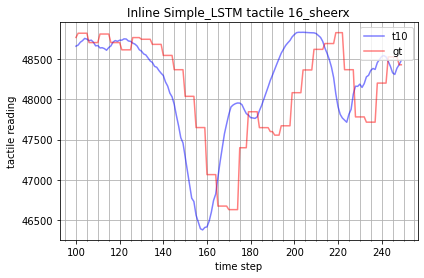

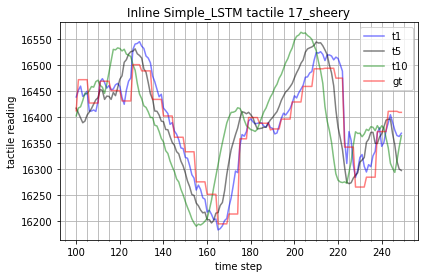

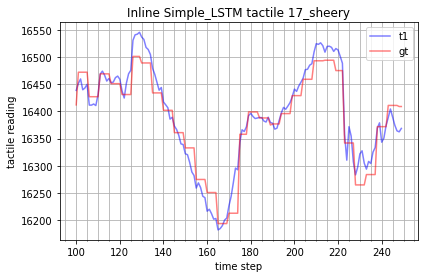

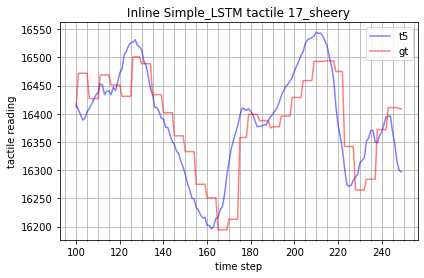

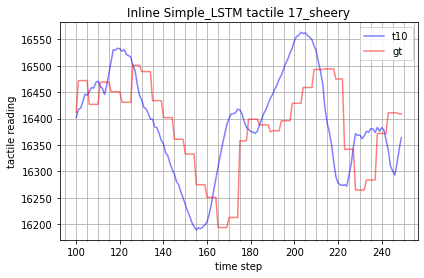

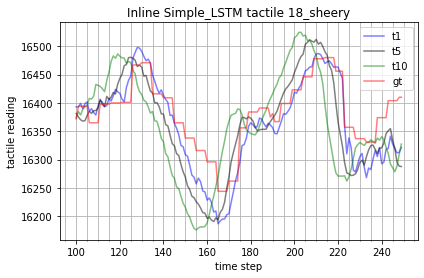

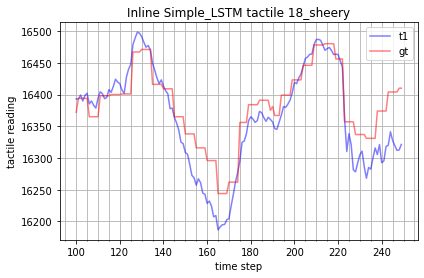

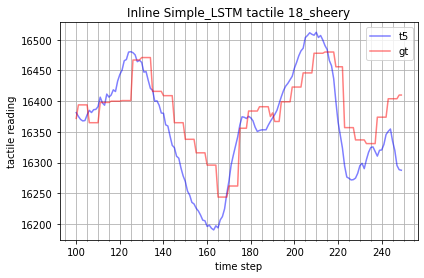

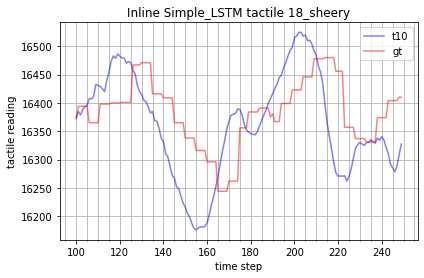

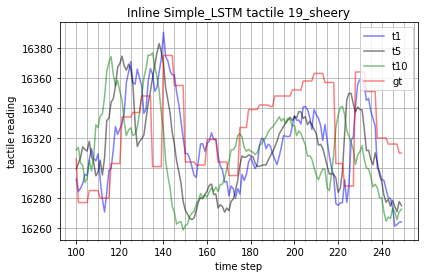

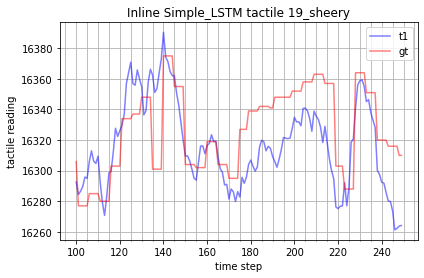

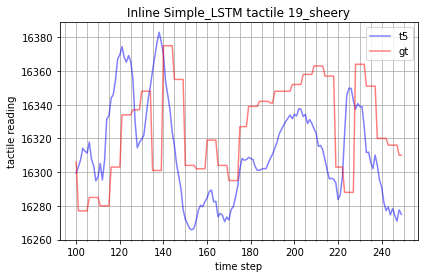

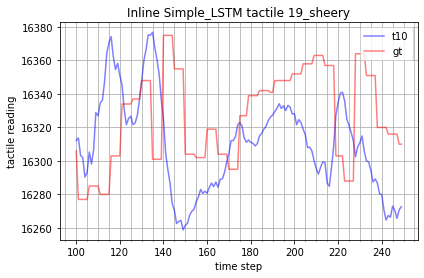

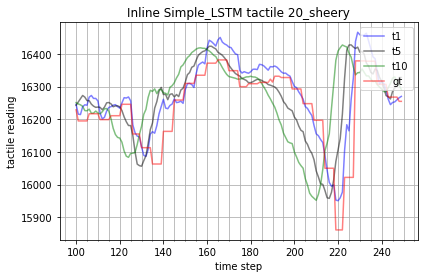

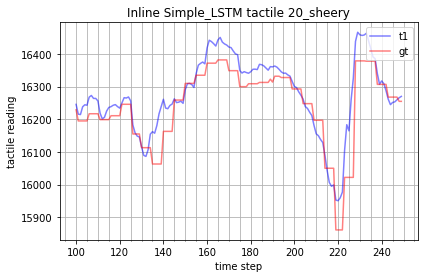

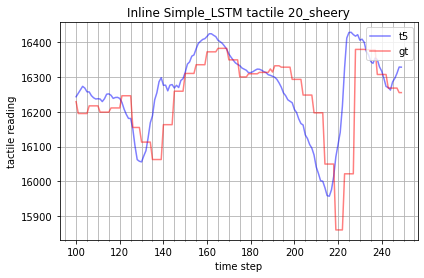

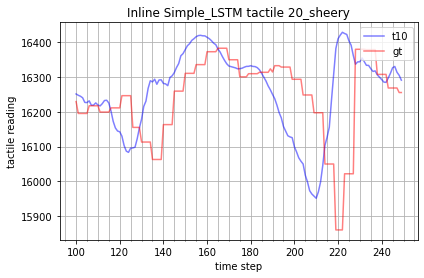

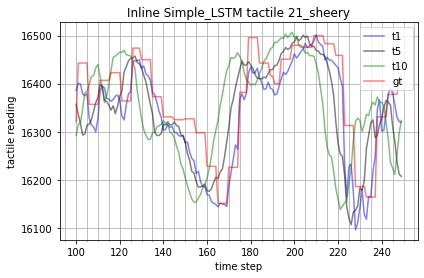

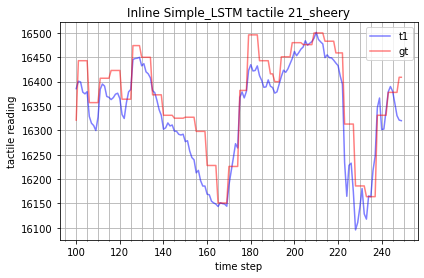

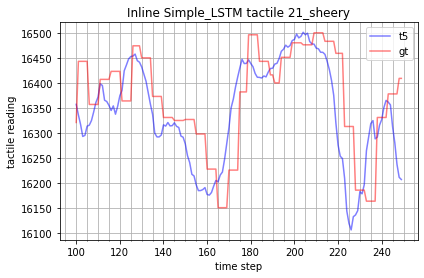

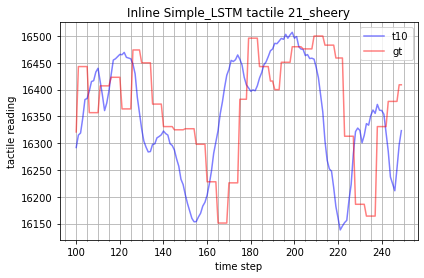

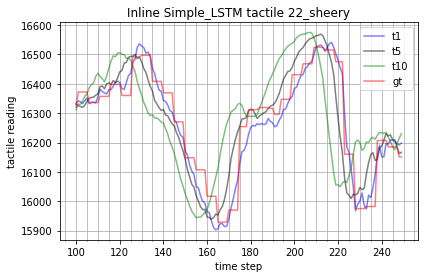

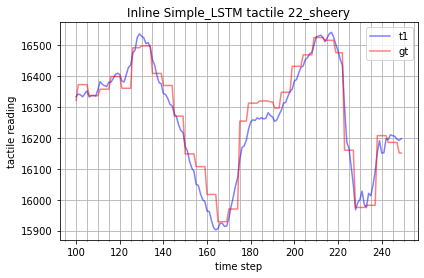

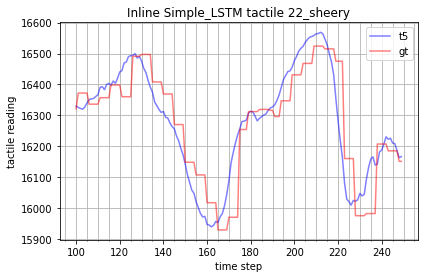

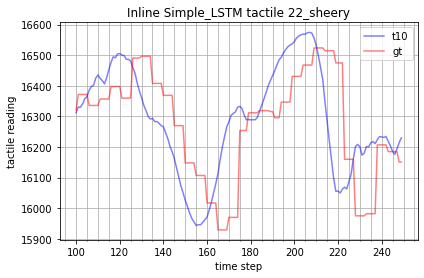

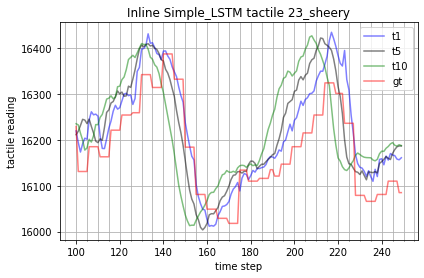

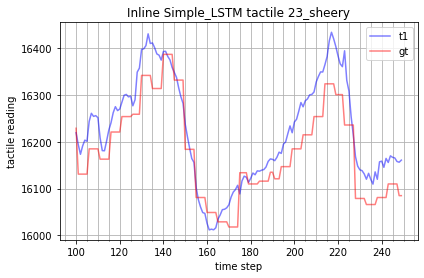

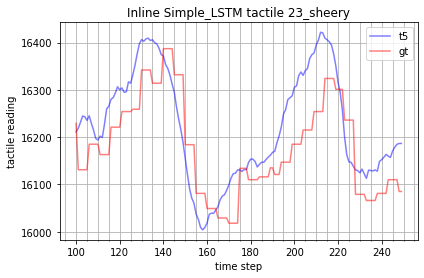

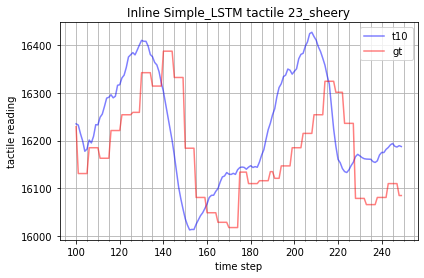

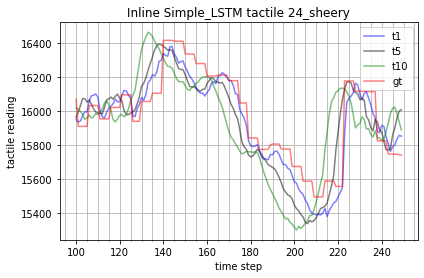

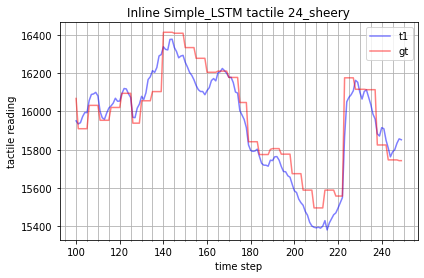

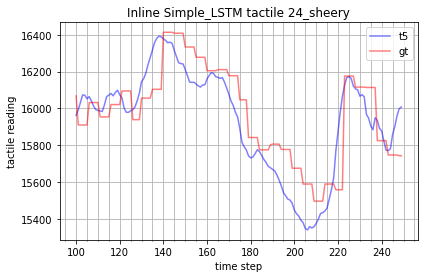

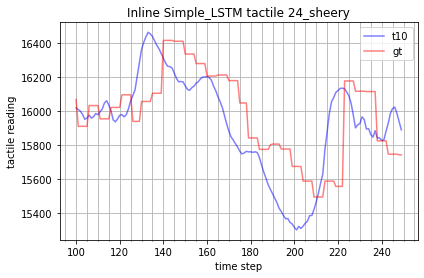

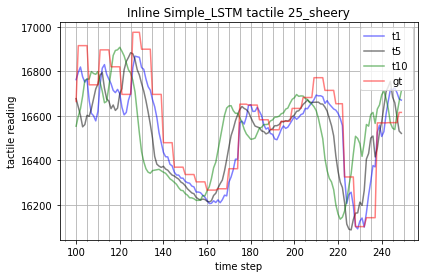

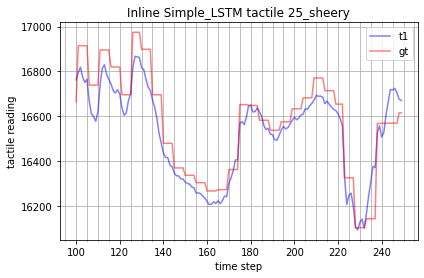

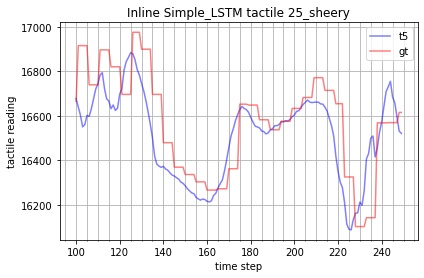

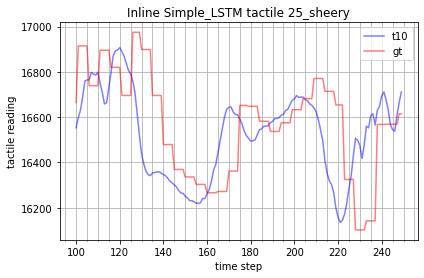

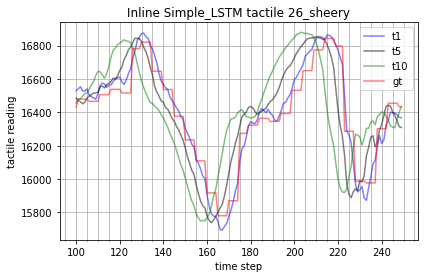

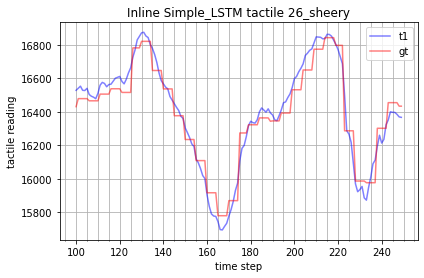

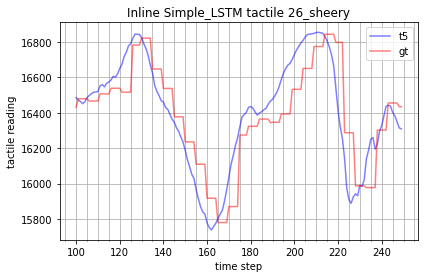

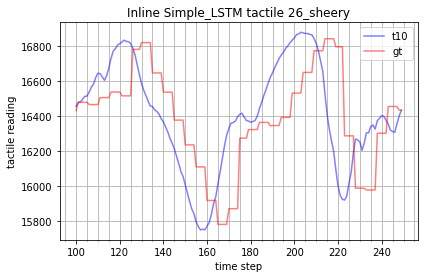

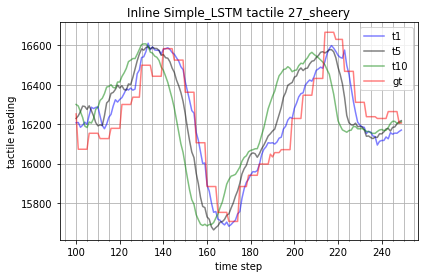

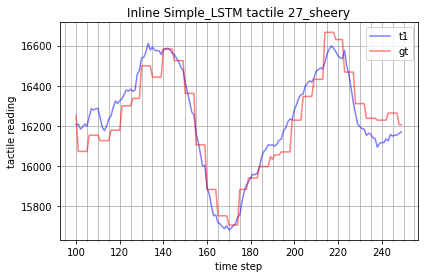

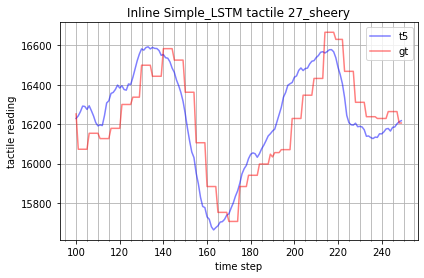

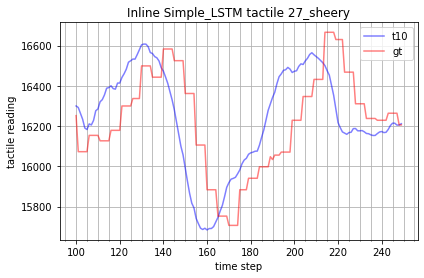

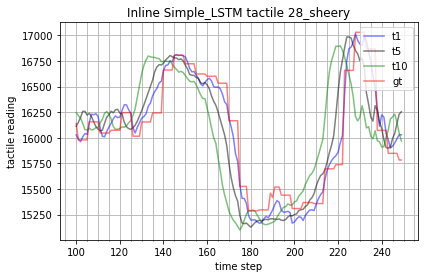

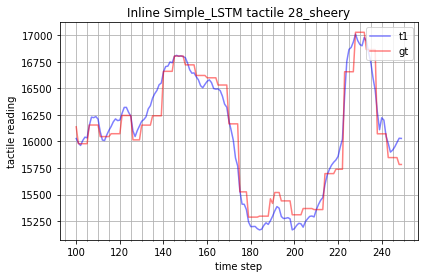

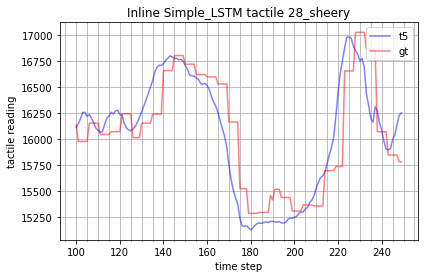

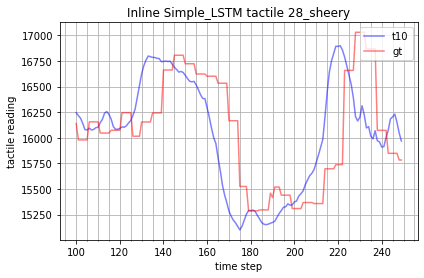

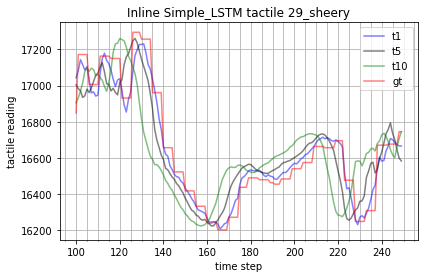

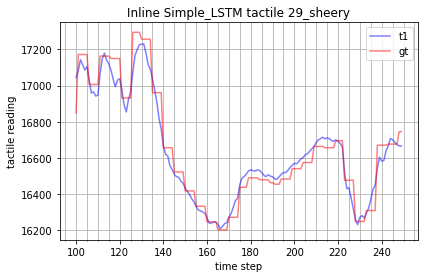

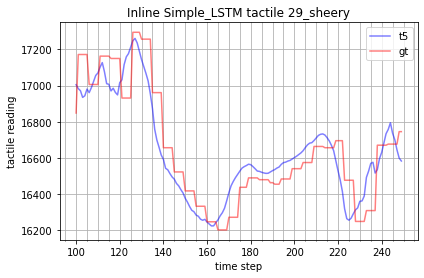

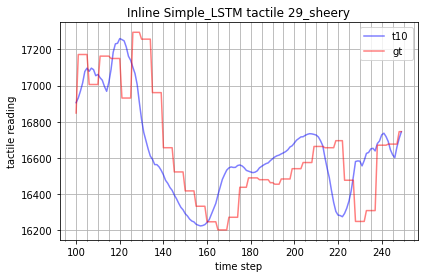

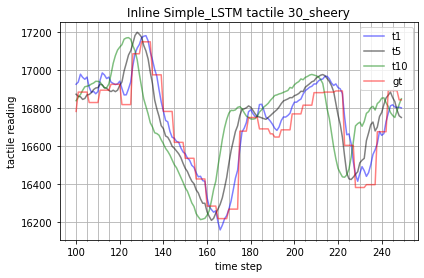

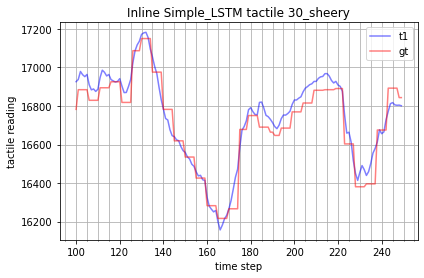

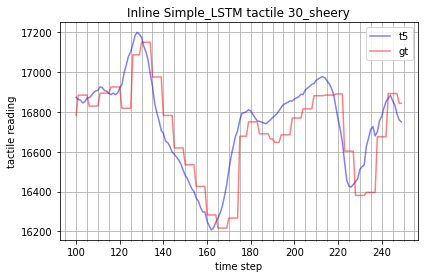

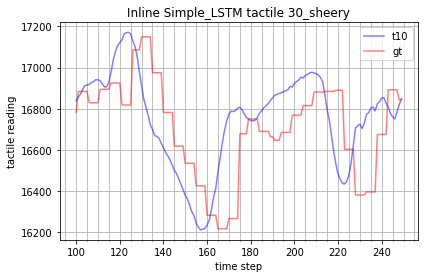

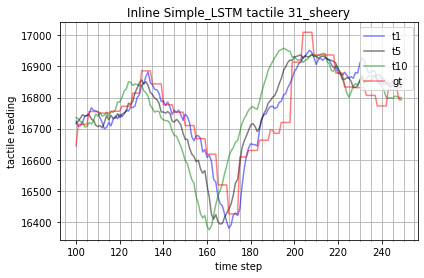

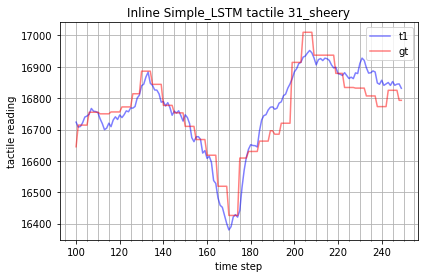

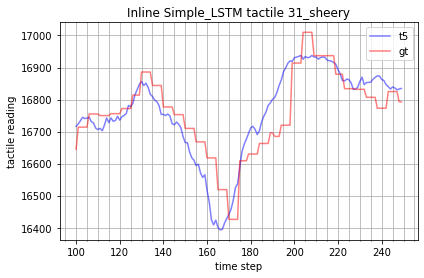

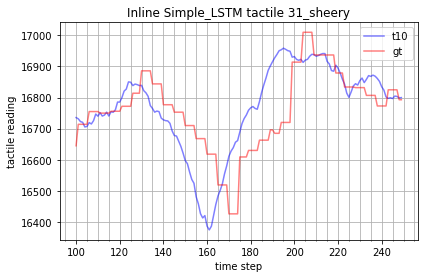

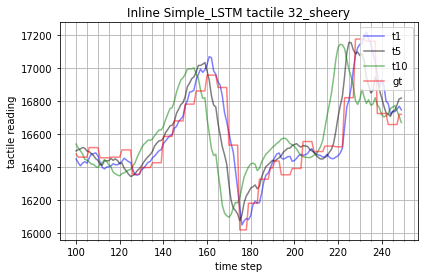

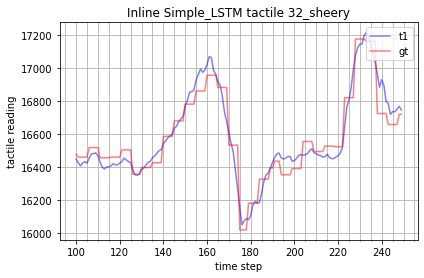

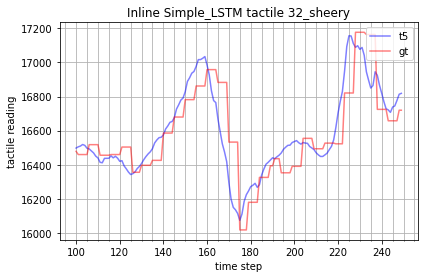

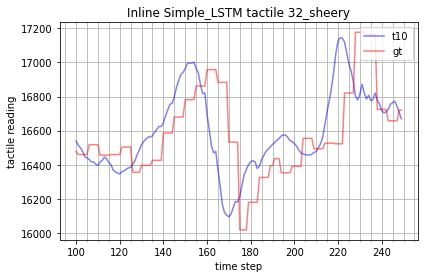

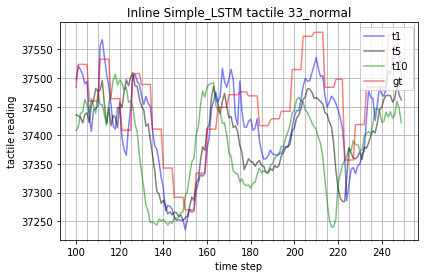

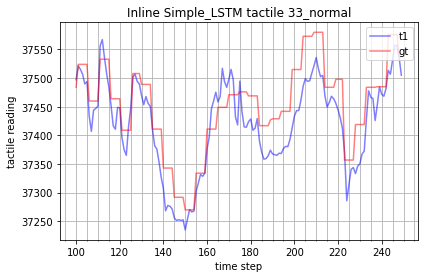

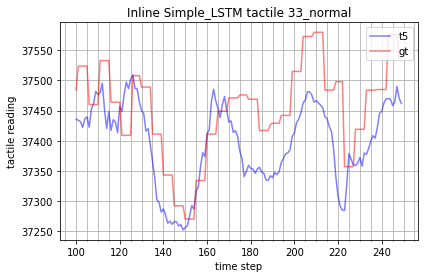

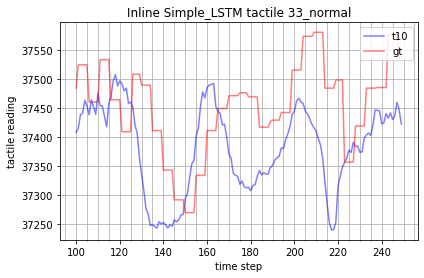

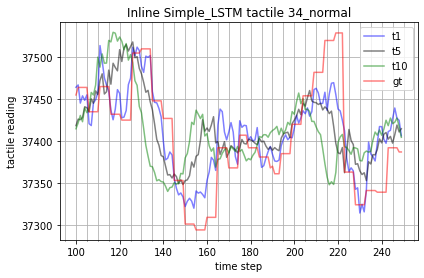

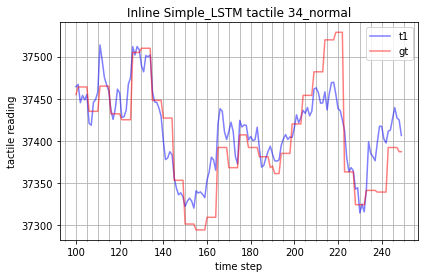

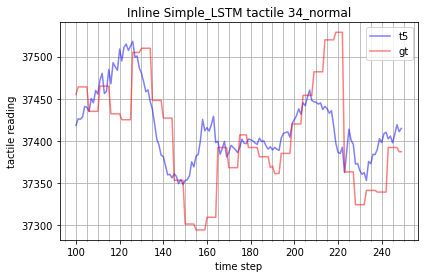

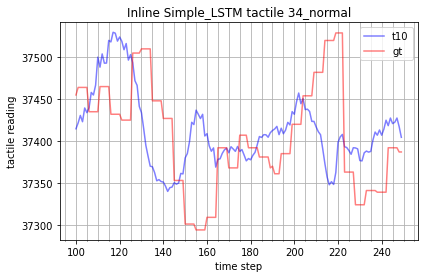

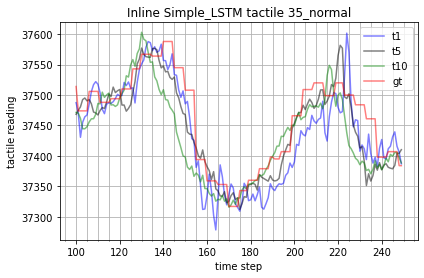

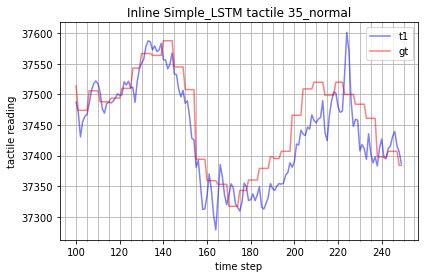

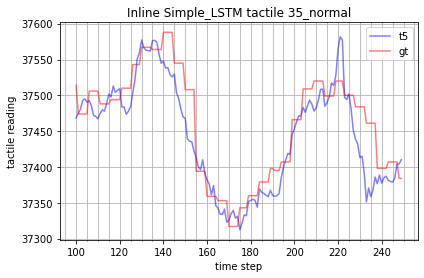

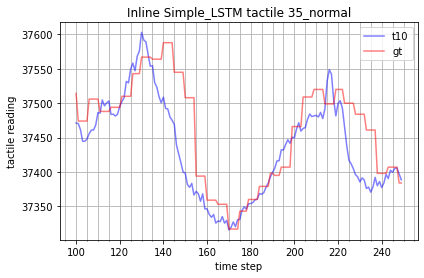

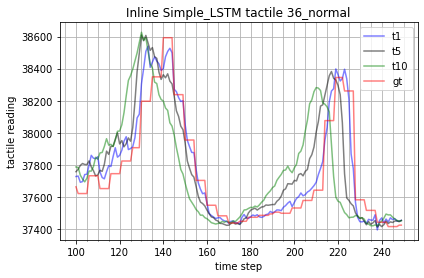

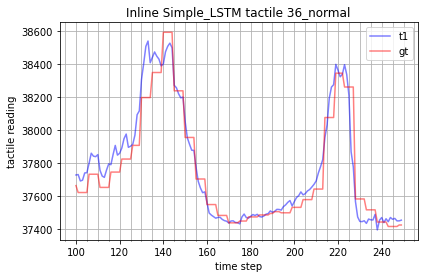

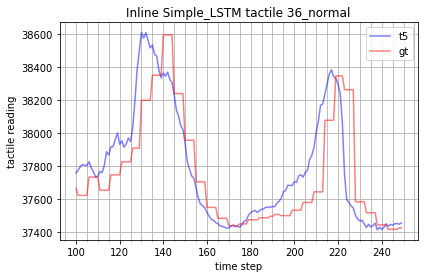

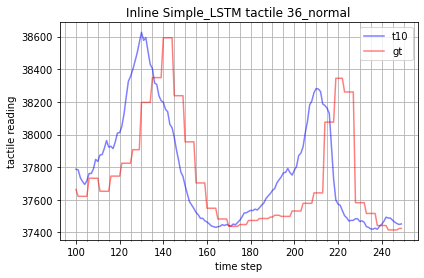

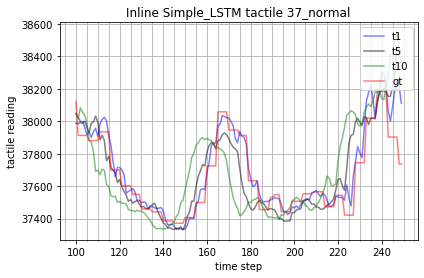

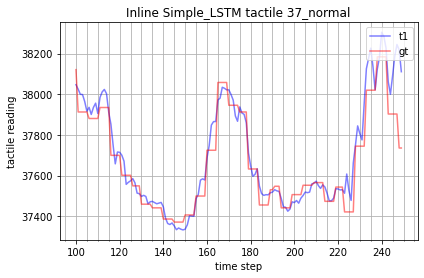

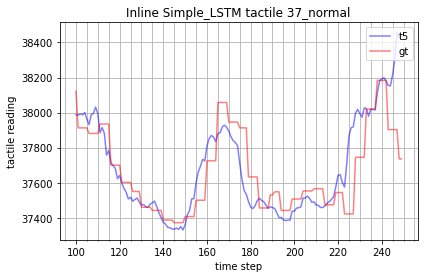

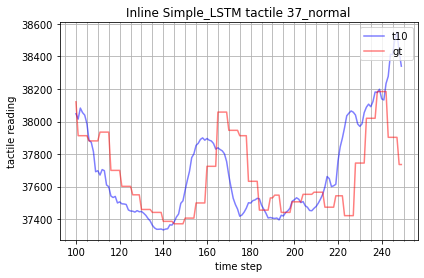

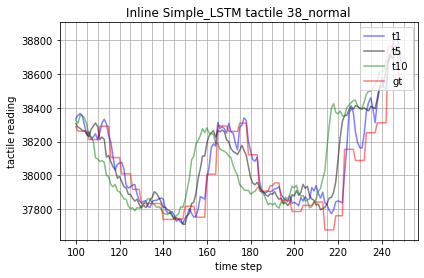

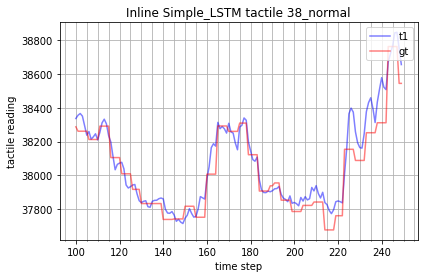

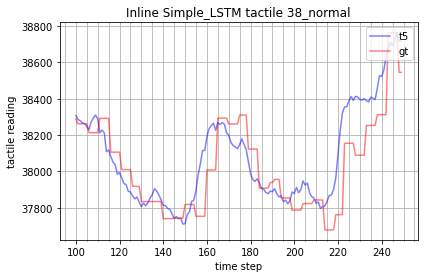

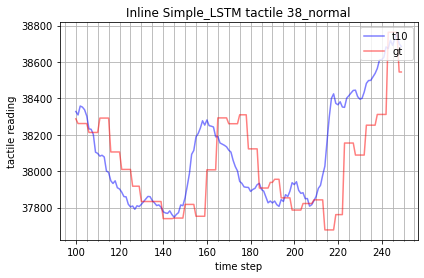

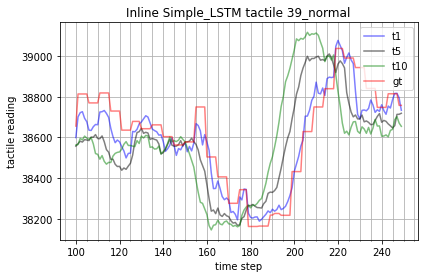

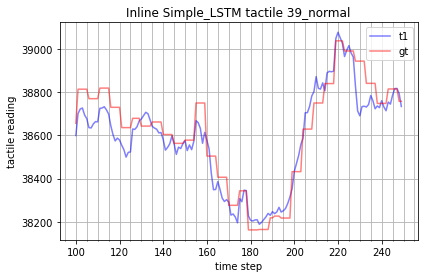

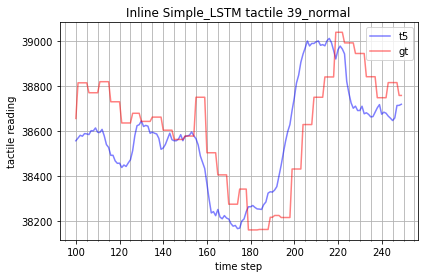

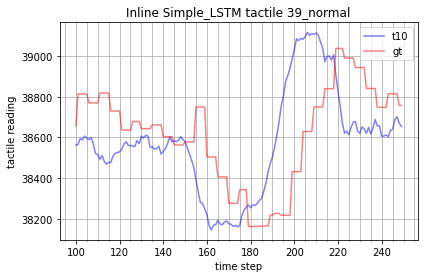

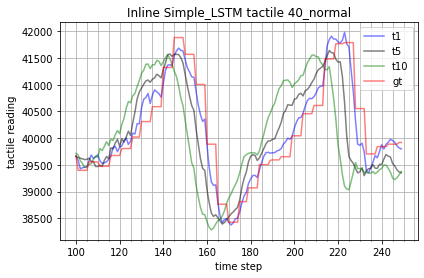

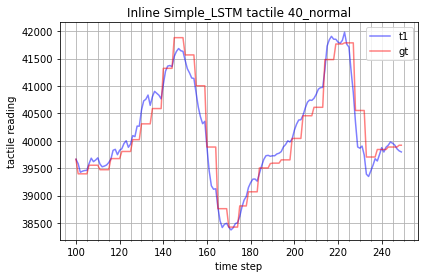

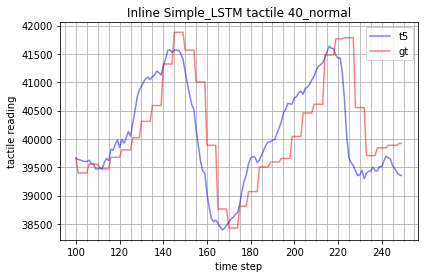

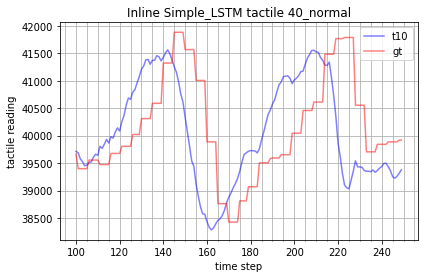

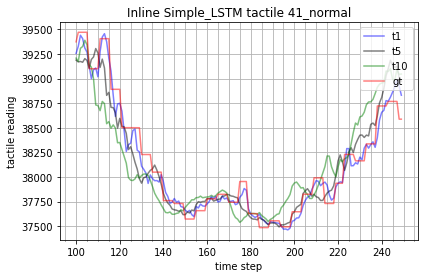

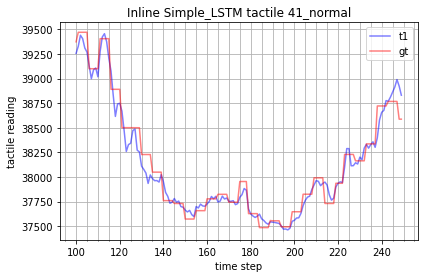

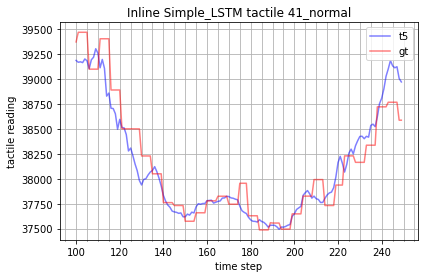

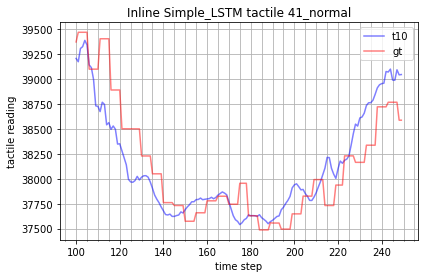

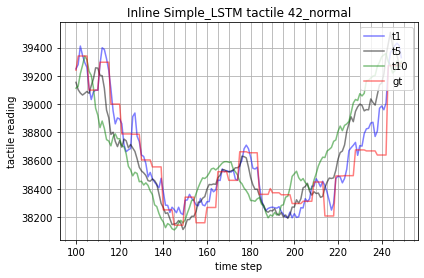

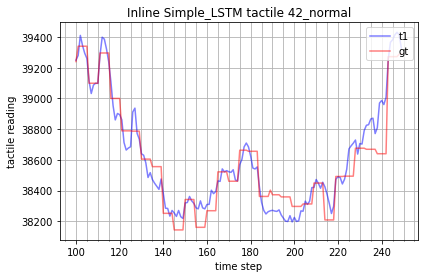

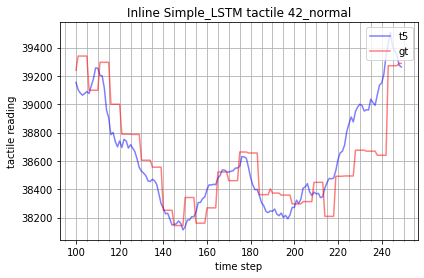

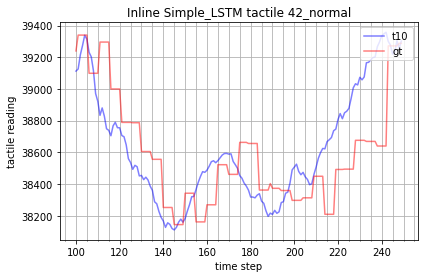

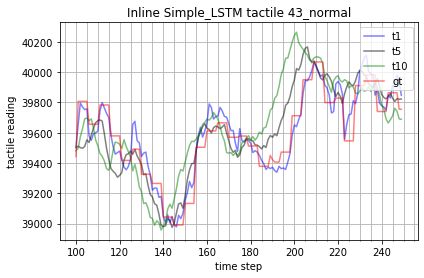

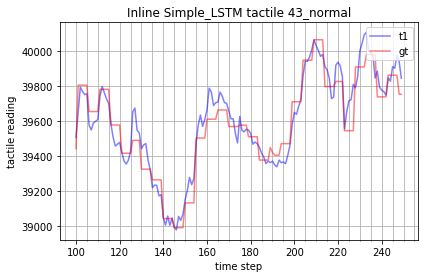

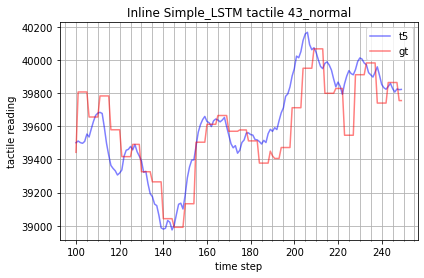

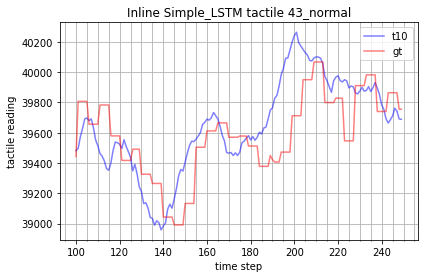

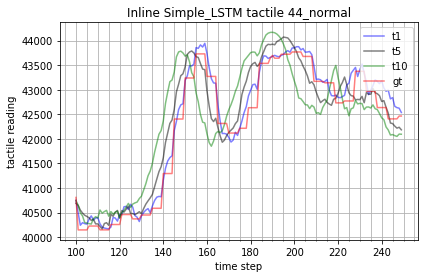

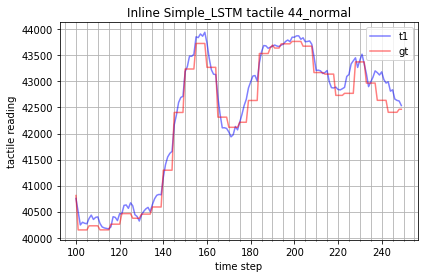

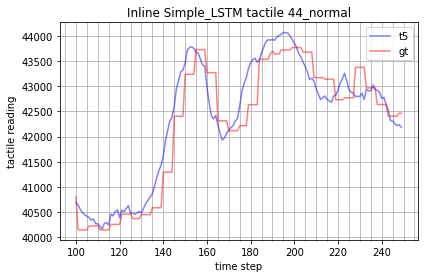

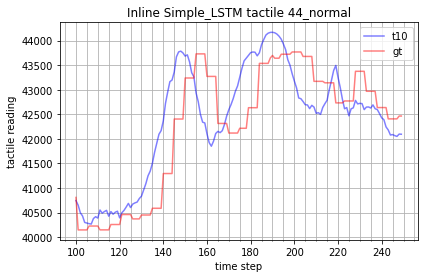

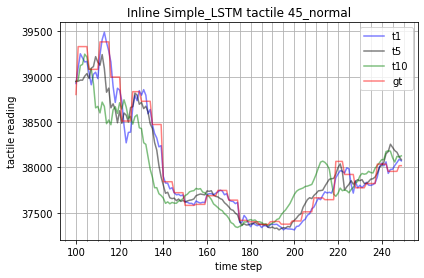

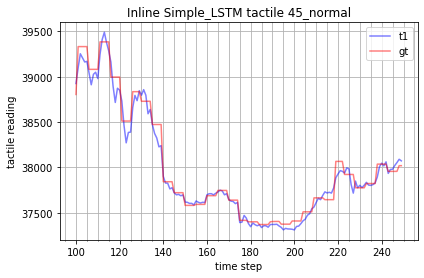

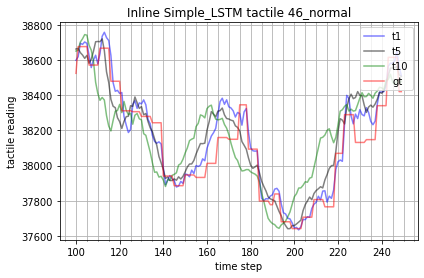

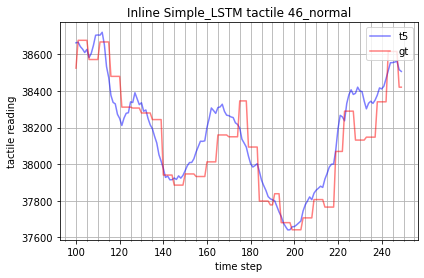

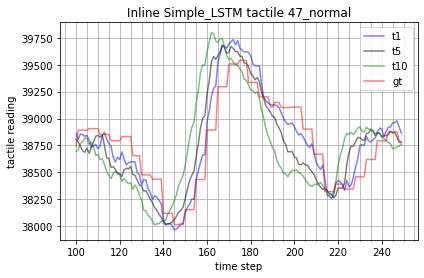

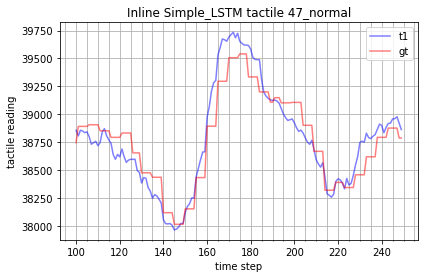

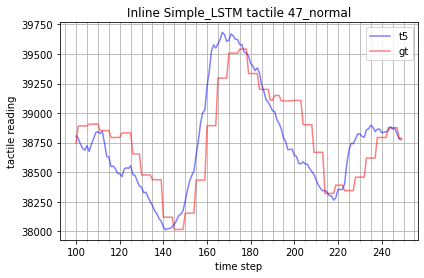

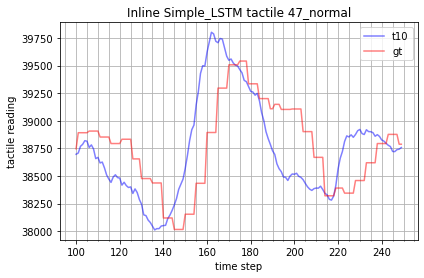

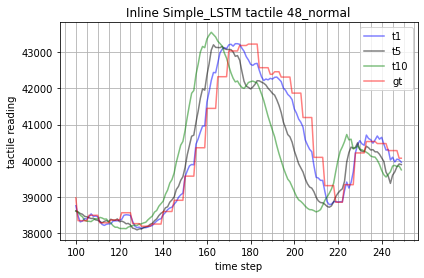

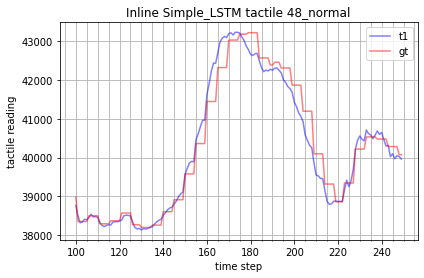

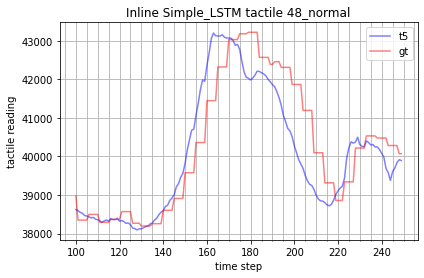

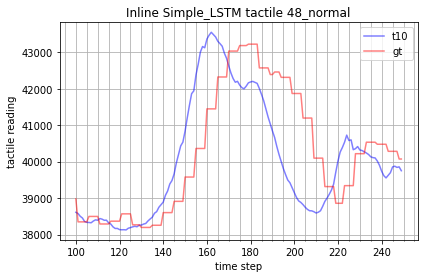

In [48]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
test_t = []
test_d1 = []
test_d2 = []
test_a = []
experiment_to_test = len(p) - 1  # experiment 106 as its the last one


for batchset in range(len(tactile_predictions)):
    for batch in range(len(tactile_predictions[batchset][time_step_to_test_t9])):
        experiment = experiment_time_steps[batchset][0][batch][0].numpy()
        time_step = experiment_time_steps[batchset][1][batch][0].numpy()
        if experiment == experiment_to_test:
            predicted_data_t1.append(tactile_predictions[batchset][time_step_to_test_t1][batch])
            predicted_data_t5.append(tactile_predictions[batchset][time_step_to_test_t5][batch])
            predicted_data_t9.append(tactile_predictions[batchset][time_step_to_test_t9][batch])
            groundtruth_data.append(tactile_groundtruth[batchset][0][batch])
            time_stepsto_plot.append(time_step.item())

# experiment_to_test = len(p) - 1  # experiment 106 as its the last one
# for index, batch_set in enumerate(tactile_predictions):
#     for batch in range(0, len(batch_set[0])):
#         experiment = experiment_time_steps[index][0][batch][0].numpy()
#         time_step = experiment_time_steps[index][1][batch][0].numpy()
#         if experiment == experiment_to_test:
#             predicted_data_t1.append(batch_set[time_step_to_test_t1][batch])
#             predicted_data_t5.append(batch_set[time_step_to_test_t5][batch])
#             predicted_data_t9.append(batch_set[time_step_to_test_t9][batch])
#             groundtruth_data.append(tactile_groundtruth[index][time_step_to_test_t1][batch])
#             time_stepsto_plot.append(time_step.item())
            
#             test_t.append(tactile_gt_test[index][time_step_to_test_t1][batch])
#             test_d1.append(tactile_gt_d1_test[index][time_step_to_test_t1][batch])
#             test_d2.append(tactile_gt_d2_test[index][time_step_to_test_t1][batch])
#             test_a.append(action_test[index][time_step_to_test_t1][batch])

print(time_stepsto_plot)
# test data
index = 0
plot_range_start = 100 # 0
plot_range_stop  = 250 # len(time_stepsto_plot)
experiment_to_test = 106
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][index].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="k", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="g", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '_50step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.savefig(model_path + '/' + str(experiment_to_test) + '_50step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T1_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="b", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '_50step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T25_tactile_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="b", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index) + "_" + titles[j])
        plt.savefig(model_path + '/' + str(experiment_to_test) + '_50step_prediction/timestep_' + str(plot_range_start) + "_" + str(plot_range_stop) + '_T10_tactile_' + str(index) + '.png', dpi=300)
        plt.show()

In [ ]:
## testing for longer lengths:
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze().permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
        print(action.shape)
        print(tactile[0])
        print(tactilederiv1.shape)
        print(tactilederiv2.shape)
        break

test_t_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_t])).unsqueeze(1)
test_d1_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_d1])).unsqueeze(1)
test_d2_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_d2])).unsqueeze(1)
test_a_sequence = torch.tensor(np.array([i.cpu().detach().numpy() for i in test_a])).unsqueeze(1)

test_t_sequence = torch.cat((test_t_sequence, test_t_sequence), dim=1)
test_d1_sequence = torch.cat((test_d1_sequence, test_d1_sequence), dim=1)
test_d2_sequence = torch.cat((test_d2_sequence, test_d2_sequence), dim=1)
test_a_sequence = torch.cat((test_a_sequence, test_a_sequence), dim=1)

print(test_t_sequence[0])

print(test_t_sequence.shape)
print(test_d1_sequence.shape)
print(test_d2_sequence.shape)
print(test_a_sequence.shape)

context_frames = 10

prediction = model.forward(test_t_sequence.to(device),  test_a_sequence.to(device), test_d1_sequence.to(device), test_d2_sequence.to(device))
print(prediction.shape)
for i in range(48):
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('time step')
    ax1.set_ylabel('tactile reading')
    ax1.plot([None for i in range(context_frames-1)] + [i for i in prediction[:,0,i].cpu().detach().numpy()], label="t10")
    ax1.plot(test_t_sequence[:,0,i].cpu().detach().numpy(), label="gt")
    ax1.tick_params(axis='y')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.subplots_adjust(top=0.90)
    ax1.legend(loc="upper right")

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='minor', length=1, color='k')
    ax1.grid(which='minor')
    ax1.grid(which='major')

    plt.title("Full timestep prediction from" + str(context_frames) + "frames context simple_LSTM tactile " + str(i))
    plt.savefig(model_path + str(experiment_to_test) + '_full_prediction_sequence/contextframes_ ' + str(context_frames) + 'tactile_' + str(i) + '.png', dpi=300)
    plt.show()

In [ ]:
# TEST THE MODEL ON KENNY'S DATASET